<h1 align=center><font size = 6>Choosing Location for a Jazz Cafe in Zagreb</font></h1>

<h1 align=center><font size = 5>IBM/Coursera Applied Data Science Capstone Project</font></h1>

<font size = 3>

- <a href='#section1'>Introduction - Business Problem</a>
- <a href='#section2'>Data Acquisition and Cleansing</a>
- <a href='#section3'>Methodology</a>
- <a href='#section4'>Results</a>
- <a href='#section5'>Discussion</a>
- <a href='#section6'>Conclusion</a>
</font>

<a id='section1'></a>

## Introduction - Business Problem

For many years Zagreb has been attracting tourists and businesses from all over the world. The capital of Croatia and its biggest city, Zagreb is known for its interesting architecture, pedestrian zones and parks, and rich cultural life.

This project is **targeted to stakeholders who are considering opening a jazz cafe in Zagreb**. 

Zagreb has a vibrant nightlife, with numerous cafes, bars, nightclubs, and lounges. They are mostly concentrated in the city center. Although this seems the ideal location for a jazz cafe, the competition among musical venues in this area may be high. In this project, we will explore the neighborhoods of Zagreb and try to **find the best location for a jazz cafe**.

We assume that a desirable location for a jazz cafe would be a neighborhood that is similar to the city center, but not necessarily close to it. It would be located in an 'artistic' environment - close to arts galleries, theaters, performance arts centers, etc. It would have some nightlife spots nearby, but preferably no competing musical venues, such as jazz cafes or clubs. 

<a id='section2'></a> 

## Data Acqusition and Cleansing

Download the libraries

In [3]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopy.distance

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if not installed
import folium # map rendering library
from folium.plugins import HeatMap

from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


### Geolocation Data

For geolocations of the neighborhoods we will be using zagreb_croatia_places.geojson file that can be found at 
https://www.nextzen.org/metro-extracts/index.html#zagreb_croatia

I have saved it to my local directory and renamed zagreb_croatia_places.json.

In [4]:
with open('zagreb_croatia_places.json') as json_data:
    zagreb_data = json.load(json_data)

#extract 'features' element    
neighborhoods_data = zagreb_data['features']

Let's take a look at the data:

In [5]:
neighborhoods_data[1]

{'type': 'Feature',
 'properties': {'id': 2.0,
  'osm_id': 331099862.0,
  'name': 'Dugave',
  'type': 'neighbourhood',
  'z_order': 2.0,
  'population': None},
 'geometry': {'type': 'Point',
  'coordinates': [15.997999421868, 45.76503689132497]}}

From each feature we extract **name, type and coordinates**, and store in a dataframe. Let's call it raw_neighborhood, as opposed to a processed version.

In [6]:
# create a dataframe and populate it with the neighborhood data
column_names = ['Type', 'Name', 'Latitude', 'Longitude'] 

# instantiate the dataframe
raw_neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    neighborhood_type = data['properties']['type'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    raw_neighborhoods = raw_neighborhoods.append({'Type': neighborhood_type,
                                          'Name': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
print(raw_neighborhoods.shape)
raw_neighborhoods.head()

(169, 4)


,Type,Name,Latitude,Longitude
0,village,Hrvatski Leskovac,45.744581,15.890419
1,neighbourhood,Dugave,45.765037,15.997999
2,neighbourhood,Botinec,45.754697,15.936869
3,suburb,None,45.762938,15.987479
4,neighbourhood,Travno,45.770753,15.997835


### Getting Population Density Data

The data for population densities of Zagreb can be found here: https://en.wikipedia.org/wiki/Districts_of_Zagreb

Let's web-scrape it and store the data in a dataframe.

In [7]:
# if we already did it, load the data from file
loaded = False
try:
    with open('zagreb_districts.csv', 'rb') as f:
        df_zagreb_districts = pd.read_csv(f)
    print('zagreb_districts.csv loaded.')
    loaded = True
except:
    pass

zagreb_districts.csv loaded.


In [8]:
if loaded == False:
    
    url='https://en.wikipedia.org/wiki/Districts_of_Zagreb'
    wiki_page=requests.get(url).text
    
    soup = BeautifulSoup(wiki_page, 'lxml')
    
    div = soup.find('div', id="mw-content-text")
    table = div.find('table', class_=None)
    tr=table.find_all('tr')
    
    df_zagreb_districts = pd.DataFrame(columns = ['District', 'Size', 'Population', 'Density'])
    
    for i in range(2, len(tr)-1):
        row = tr[i]
        td = row.find_all('td')
        district = td[1].text.strip()
        href = td[1].a.get('href').strip()
        size=td[2].text.strip()
        population = td[3].text.strip()
        population = int(population.replace(',', ''))
        density = td[4].text.strip()
        density = int(density.replace(',', ''))

        df_zagreb_districts = df_zagreb_districts.append({'District': district,
                                              'Size': size,
                                              'Population': population,
                                               'Density': density}, ignore_index=True)

    df_zagreb_districts.to_csv(r'zagreb_districts.csv', index=False)
    

In [9]:
df_zagreb_districts.head()

,District,Size,Population,Density
0,Donji grad(Lower town),3,37024,12341
1,Gornji Grad–Medveščak(Upper town–Medveščak),10,30962,3096
2,Trnje,7,42282,6040
3,Maksimir,14,48902,3493
4,Peščenica – Žitnjak,35,56487,1614


Note: The population data is per district, which is a larger division than a neighborhood (district is composed of neighborhoods). Some districts contain of just one neighborhood with the same name.

### Examining and Cleansing the Data

Let's examine the neighborhood data:

In [10]:
raw_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 4 columns):
Type         169 non-null object
Name         167 non-null object
Latitude     169 non-null float64
Longitude    169 non-null float64
dtypes: float64(2), object(2)
memory usage: 5.4+ KB


There are 169 items total. However, we see that two items have **null names**. Let's drop these rows.

In [11]:
neighborhoods = raw_neighborhoods[raw_neighborhoods['Name'].notnull()]
neighborhoods.shape

(167, 4)

We also see that the data contains entries of different types:

In [12]:
neighborhoods['Type'].unique()

array(['village', 'neighbourhood', 'suburb', 'locality', 'city', 'hamlet',
       'town'], dtype=object)

Let's **drop 'village' and 'hamlet'**, since we are interested only in Zagreb proper.

In [13]:
neighborhoods = neighborhoods[neighborhoods['Type'] != 'village']
neighborhoods = neighborhoods[neighborhoods['Type'] != 'hamlet']
neighborhoods.shape

(139, 4)

Let's check if there are items with **duplicate names**:

In [14]:
print(any(neighborhoods['Name'].duplicated()))

True


In [15]:
duplicates = neighborhoods.loc[neighborhoods.duplicated('Name', keep=False)]
duplicates

,Type,Name,Latitude,Longitude
19,neighbourhood,Trnje,45.797163,15.974574
27,neighbourhood,Črnomerec,45.816528,15.936323
73,neighbourhood,Maksimir,45.820726,16.003952
118,suburb,Trnje,45.797038,15.982495
119,suburb,Črnomerec,45.827382,15.933554
120,suburb,Maksimir,45.833312,16.010151


So we have three pairs of duplicates. Let's see if we want to keep both entries. Let's see how far apart are they.

In [16]:
trnje1 = [neighborhoods.loc[19]['Latitude'], neighborhoods.loc[19]['Longitude']]
trnje2 = [neighborhoods.loc[118]['Latitude'], neighborhoods.loc[118]['Longitude']]

crnomerec1 = [neighborhoods.loc[27]['Latitude'], neighborhoods.loc[27]['Longitude']]
crnomerec2 = [neighborhoods.loc[119]['Latitude'], neighborhoods.loc[119]['Longitude']]

maksimir1 = [neighborhoods.loc[73]['Latitude'], neighborhoods.loc[73]['Longitude']]
maksimir2 = [neighborhoods.loc[120]['Latitude'], neighborhoods.loc[120]['Longitude']]

print('Distance between Trnje points: {}, Distance between Crnomerec points: {}, \
                                    Distance between Maksimir points: {}'.format(
                                        geopy.distance.distance(trnje1, trnje2).km,
                                        geopy.distance.distance(crnomerec1, crnomerec2).km,
                                        geopy.distance.distance(maksimir1, maksimir2).km))


Distance between Trnje points: 0.6160135270941407, Distance between Crnomerec points: 1.22535950389474,                                     Distance between Maksimir points: 1.4795247443282378


So we see that these duplicate names actually represent different locations. Let's keep both, and rename the second location by adding '-Suburb' to the name.

In [17]:
neighborhoods.loc[118,'Name'] = 'Trnje-Suburb'
neighborhoods.loc[119,'Name'] = 'Črnomerec-Suburb'
neighborhoods.loc[120,'Name'] = 'Maksimir-Suburb'

In [18]:
neighborhoods.head()

,Type,Name,Latitude,Longitude
1,neighbourhood,Dugave,45.765037,15.997999
2,neighbourhood,Botinec,45.754697,15.936869
4,neighbourhood,Travno,45.770753,15.997835
5,neighbourhood,Utrina,45.775019,15.997538
6,neighbourhood,Lanište,45.772431,15.947718


Let's rename column 'Name' to 'Neighborhood' and drop column 'Type'

In [19]:
neighborhoods.rename(columns={'Name': 'Neighborhood'}, inplace=True)
neighborhoods.drop('Type', axis=1, inplace=True)
neighborhoods.head()

,Neighborhood,Latitude,Longitude
1,Dugave,45.765037,15.997999
2,Botinec,45.754697,15.936869
4,Travno,45.770753,15.997835
5,Utrina,45.775019,15.997538
6,Lanište,45.772431,15.947718


Let's show the neighborhoods on the map. 
Get the location of Zagreb, and center the map around it.

In [20]:
address = 'Zagreb, HR'

geolocator = Nominatim(user_agent="zagreb_explorer")
location = geolocator.geocode(address)
zagreb_latitude = location.latitude
zagreb_longitude = location.longitude
print('The geograpical coordinate of Zagreb are {}, {}.'.format(zagreb_latitude, zagreb_longitude))

The geograpical coordinate of Zagreb are 45.813177, 15.977048.


In [21]:
# create map centered at Zagreb center with neighborhood locations superimposed
map_zagreb = folium.Map(location=[zagreb_latitude, zagreb_longitude], zoom_start=12)

# add markers to map
for lat, lng, neigh_name in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neigh_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zagreb)

folium.Marker(
            [zagreb_latitude, zagreb_longitude],
            popup='Zagreb',
            ).add_to(map_zagreb)    
map_zagreb

### Extending the Data

We see that we don't have enough points in the area north, west and east from Zagreb center. Let's extend our dataset. 
The area north of the center is called Gornji Grad (Upper Town). The neighborhoods of this district are listed here:
https://en.wikipedia.org/wiki/Gornji_Grad%E2%80%93Medve%C5%A1%C4%8Dak

I have manually extracted the list of neighborhoods. 

In [22]:
Gornji_Grad = ['Gornji grad', 'Gupčeva zvijezda', 'Kaptol', 'Kraljevec', 'Ksaver', 'Medveščak', 'Mirogoj', 'Nova Ves', \
       'Pantovčak', 'Petrova', 'Ribnjak', 'Šalata', 'Tkalčićeva Street', 'Tuškanac', 'Vočarska', 'Zelengaj']

Let's select from this list those neighborhood that we don't already have in our dataset, and store them in missing_neighbs list.

In [23]:
# Create a list of neighborhoods to extend our data with.
missing_neighbs = []

neighbs = neighborhoods['Neighborhood'].values
for item in Gornji_Grad:
    if item not in neighbs:
        missing_neighbs.append(item)
        
print('Found {} missing neighborhoods'.format(len(missing_neighbs)))

Found 10 missing neighborhoods


Let's get the geolocations of these neighborhoods and store them in added_neighborhoods dataframe.
We specify the district Medveščak to avoid getting places with the same name but in different parts of Zagreb county.

In [24]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
added_neighborhoods = pd.DataFrame(columns=column_names)

for item in missing_neighbs:
    address = item+', Zagreb, Medveščak, HR'
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    added_neighborhoods = added_neighborhoods.append({'Neighborhood': item,
                                                      'Latitude': latitude,
                                                      'Longitude': longitude}, ignore_index=True)
added_neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Gornji grad,45.812318,15.983975
1,Gupčeva zvijezda,45.828010,15.978919
2,Kaptol,45.815155,15.978583
3,Kraljevec,45.840670,15.965235
4,Mirogoj,45.835180,15.983934


Now let's add two points west and east of the center. 

First, let's define a couple of helper functions. 

In [25]:
# Get geolocation of the neighborhood from our neighborhood dataframe.
def getNeighborhoodLocation(neighborhood):
    lat = neighborhoods[neighborhoods['Neighborhood'] == neighborhood]['Latitude'].values[0]
    lng = neighborhoods[neighborhoods['Neighborhood'] == neighborhood]['Longitude'].values[0]
    location = [lat, lng]
    return location

In [26]:
#Get geolocation of a point between two geolocations. Here we assume that the two points are close enough
#so that we can treat the locations as planar coordinates
def findMidpoint(location1, location2):
    mp = [(location1[0] + location2[0])/2, (location1[1] + location2[1])/2]
    return mp

Looking at the map, we can define one point as midway between Donji Grad and Peščenica, and the other midway between Donji Grad and Kustošija. 

In [27]:
pescenica = getNeighborhoodLocation('Peščenica')
kustosija = getNeighborhoodLocation('Kustošija')
donjigrad = getNeighborhoodLocation('Donji grad')

donjigrad_east = findMidpoint(donjigrad, pescenica)
donjigrad_west = findMidpoint(donjigrad, kustosija)
print('Donji grad east: {},{}, Donji grad west: {}, {}'.format(donjigrad_east[0], donjigrad_east[1],\
                                                              donjigrad_west[0], donjigrad_west[1]))

Donji grad east: 45.81120101933388,15.993677544953684, Donji grad west: 45.812015907960415, 15.949794509983903


Let's add these points to the added_neighborhood dataframe:

In [28]:
added_neighborhoods = added_neighborhoods.append({
                                          'Neighborhood': 'Donji grad - East',
                                          'Latitude': donjigrad_east[0],
                                          'Longitude': donjigrad_east[1]}, ignore_index=True)
added_neighborhoods = added_neighborhoods.append({
                                          'Neighborhood': 'Donji grad - West',
                                          'Latitude': donjigrad_west[0],
                                          'Longitude': donjigrad_west[1]}, ignore_index=True)
print('Added {} points.'.format(added_neighborhoods.shape[0]))
added_neighborhoods.head()      

Added 12 points.


,Neighborhood,Latitude,Longitude
0,Gornji grad,45.812318,15.983975
1,Gupčeva zvijezda,45.828010,15.978919
2,Kaptol,45.815155,15.978583
3,Kraljevec,45.840670,15.965235
4,Mirogoj,45.835180,15.983934


Lets visualize the added neighborhood on the map. We will show them in red.

In [29]:
# create map of Zagreb using latitude and longitude values
map_zagreb = folium.Map(location=[zagreb_latitude, zagreb_longitude], zoom_start=12)

# add markers to map
for lat, lng, neigh_name in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neigh_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zagreb)
    

for lat, lng, neigh_name in zip(added_neighborhoods['Latitude'], added_neighborhoods['Longitude'], \
                                added_neighborhoods['Neighborhood']):
    label = '{}'.format(neigh_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_zagreb)

folium.Marker(
            [zagreb_latitude, zagreb_longitude],
            popup='Zagreb',
            ).add_to(map_zagreb)    

map_zagreb

Let's append added_neighborhoods to our neighborhoods table

In [30]:
neighborhoods = neighborhoods.append(added_neighborhoods)

neighborhoods = neighborhoods.reset_index(drop=True)
print(neighborhoods.shape)
neighborhoods.head()

(151, 3)


,Neighborhood,Latitude,Longitude
0,Dugave,45.765037,15.997999
1,Botinec,45.754697,15.936869
2,Travno,45.770753,15.997835
3,Utrina,45.775019,15.997538
4,Lanište,45.772431,15.947718


Let's save the processed data into a csv file in the local directory:

In [31]:
neighborhoods.to_csv(r'zagreb_neighborhoods_processed.csv', index=False )

### Getting venues with Foursquare API

We will be using Foursquare API to get venues in each neighborhood.  We use explore request:

https://api.foursquare.com/v2/venues/explore

with the following parameters: radius=500, limit=100, day=‘any’, time=‘any’, openNow=0

The last three parameters are needed to ensure that we get venues independently on whether they are currently open or not.


Let's define the parameters that we will be using in our queries.

In [97]:
#removed client ID and client secret before sharing
CLIENT_ID = '*******' # Foursquare ID
CLIENT_SECRET = '******' # Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [33]:
radius = 500
LIMIT = 100
time = 'any'
day = 'any'
openNow = 0

Let's get venues for some neighborhood and see the structure of the response.

In [34]:
dugave_lat = neighborhoods.loc[0]['Latitude'] 
dugave_lng = neighborhoods.loc[0]['Longitude']              
    
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}\
        &ll={},{}&radius={}&limit={}&time={}&day={}&openNow={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            dugave_lat, 
            dugave_lng, 
            radius, 
            LIMIT,
            time,
            day,
            openNow)
            
# make the GET request
results = requests.get(url).json()["response"]['groups'][0]['items']
results[0]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4c3c575a980320a16f778ae4',
  'name': 'Buffet Mac',
  'location': {'lat': 45.76398806616097,
   'lng': 16.001122737201435,
   'labeledLatLngs': [{'label': 'display',
     'lat': 45.76398806616097,
     'lng': 16.001122737201435}],
   'distance': 269,
   'cc': 'HR',
   'country': 'Hrvatska',
   'formattedAddress': ['Hrvatska']},
  'categories': [{'id': '4bf58dd8d48988d147941735',
    'name': 'Diner',
    'pluralName': 'Diners',
    'shortName': 'Diner',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/diner_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups': []}},
 'referralId': 'e-0-4c3c575a980320a16f778ae4-0'}


For each venue, we will store the following: **venue name, venue id,  venue location, category, and category id**. Let's define the function that gets the venues and parses the response.

In [35]:
# Get the venues for the neighborhods within given radius.
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    count = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}\
        &ll={},{}&radius={}&limit={}&time={}&day={}&openNow={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            time,
            day,
            openNow)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        if len(results) == 0:
            print('No venues returned for {}'.format(name))
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in results]) 

        count = count + 1 
    print('Queried {} neighborhoods'.format(count))
    
    #Populate the dataframe with the list of venues
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue ID',          
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Category ID']
    
    return(nearby_venues)        

Let's use this function to get the venues for all the neighborhoods.

If we have done this before, load it from file.

In [36]:
loaded = False
try:
    with open('zagreb_venues.csv', 'rb') as f:
        zagreb_venues = pd.read_csv(f)
    print('zagreb_venues.csv loaded.')
    loaded = True
except:
    pass

zagreb_venues.csv loaded.


In [37]:
if loaded == False:
    zagreb_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                       latitudes=neighborhoods['Latitude'],
                                       longitudes=neighborhoods['Longitude']
                                      )
    zagreb_venues.to_csv(r'zagreb_venues.csv', index=False)

In [38]:
print(zagreb_venues.shape)
zagreb_venues.head()

(1959, 9)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,Dugave,45.765037,15.997999,Buffet Mac,4c3c575a980320a16f778ae4,45.763988,16.001123,Diner,4bf58dd8d48988d147941735
1,Dugave,45.765037,15.997999,Play Off,4b7a4cb4f964a520e1282fe3,45.766285,16.001196,Café,4bf58dd8d48988d16d941735
2,Dugave,45.765037,15.997999,Goya Bar,4f1b2e23e4b0288a02d11b0f,45.763122,15.992952,Bar,4bf58dd8d48988d116941735
3,Dugave,45.765037,15.997999,Caffe Lupo,4c76752cb474a1cd61f8bbbf,45.762524,16.003188,Café,4bf58dd8d48988d16d941735
4,Dugave,45.765037,15.997999,Konzum,4d59795e56f2b60ce898792f,45.769046,15.999888,Grocery Store,4bf58dd8d48988d118951735


In [39]:
print('Got data for {} neighborhoods'.format(len(zagreb_venues['Neighborhood'].unique())))
print('Total number of venues: {}'.format(len(zagreb_venues['Venue ID'].unique())))

Got data for 142 neighborhoods
Total number of venues: 1350


We see that for 9 neighborhoods we did not get any venues (we have 151 neighborhoods). The reason may be there were no data in Foursquare for these venues, or the locations we queried with were off the neighborhood centers.  We will have to exclude those neighborhoods from our analysis.

### Creating Dictionaries of Categories of Interest

We will need a way to zoom-in on venues that fall into categories of our interest. Specifically, we would need to know **which venues are arts venues, which are music venues, and which are nightlife venues**. For this, let's get **Foursquare Category Hierarchy Tree**, explore it, and determine which Foursquare's categories correspond to the categories we are interested in. 

The Category Tree is returned by this request: https://api.foursquare.com/v2/venues/categories 

In case we already got the tree, load it from file. Make the request otherwise.

In [40]:
categories_data = {}
loaded = False
try:
    with open('categories.json') as json_data:
        categories_data = json.load(json_data)
        print('categories.csv loaded.')
        loaded = True
except:
    pass

categories.csv loaded.


In [41]:
if loaded == False:
    url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}&id={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                music_venues_id)
    categories_data = requests.get(url).json()
    with open('categories.json', 'w') as outfile:
        json.dump(categories_data, outfile)

Examining the category tree hierarchy, we see that we are interested in two top-level categories: 'Arts & Entertainment' and 'Nightlife Spot'. Also, we will need 'Music Venue' category, that is a child of 'Arts & Entertainment'

Let's find the roots of these categories.

In [42]:
# Initialize the root categories
arts_entertainment_categories = {}
nightlife_categories = {}
music_categories = {}

# Find the root categories for categories of our interest
for cat in categories_data['response']['categories']:
    if cat['name'] == "Arts & Entertainment":
        arts_entertainment_categories = cat
        for item in arts_entertainment_categories['categories']:
            if item['name'] == "Music Venue":
                music_categories = item
            
    elif cat['name'] == "Nightlife Spot":
        nightlife_categories = cat
        
print('Found roots of arts categories: {}, nightlife categories: {}, and music venue categories: {}'.format(\
                                        arts_entertainment_categories['name'], nightlife_categories['name'], music_categories['name']))

Found roots of arts categories: Arts & Entertainment, nightlife categories: Nightlife Spot, and music venue categories: Music Venue


Let's define a recursive function that gets all the children (recursively) of a specific category, and populates a dictionary with the categories IDs and names.

In [43]:
# Recursive function to get all the children of a specified category.
# Parameters: category - the parent category, output - the dictionary to populate.
def iterate(category, output):
    children = category['categories']
    if len(children) > 0:
        for cat in children:
            iterate(cat, output)
            continue
    output[category['id']] = category['name']

Now let's create three dictionaries, one per each category - Arts & Entertainment, Nightlife Spot, and Music Venue - and populate these dictionaries with all subcategories (recursive) of these categories. The root categories will also be added to their corresponding dictionaries. The keys will be category IDs, and the values - category names.

In [44]:
# Create the dictionaries of the categories of our interest.

arts_entertainment_categories_dict = {}
iterate(arts_entertainment_categories, arts_entertainment_categories_dict)

nightlife_categories_dict = {}
iterate(nightlife_categories, nightlife_categories_dict)

music_categories_dict = {}
iterate(music_categories, music_categories_dict)

print("Arts and Entertainment Categories\n{}\n...and more. Total: {}".format(\
                                               list(arts_entertainment_categories_dict.values())[:10],\
                                               len(arts_entertainment_categories_dict)))
print("Nightlife Categories\n{}\n...and more. Total: {}".format(\
                                                list(nightlife_categories_dict.values())[:10],\
                                                len(nightlife_categories_dict)))
print("Music Venue Categories\n{} Total: {}".format(\
                                                list(music_categories_dict.values())[:10],\
                                                len(music_categories_dict)))

Arts and Entertainment Categories
['Amphitheater', 'Aquarium', 'Arcade', 'Art Gallery', 'Bowling Alley', 'Casino', 'Circus', 'Comedy Club', 'Concert Hall', 'Country Dance Club']
...and more. Total: 65
Nightlife Categories
['Beach Bar', 'Beer Bar', 'Beer Garden', 'Champagne Bar', 'Cocktail Bar', 'Dive Bar', 'Gay Bar', 'Hookah Bar', 'Hotel Bar', 'Karaoke Bar']
...and more. Total: 25
Music Venue Categories
['Jazz Club', 'Piano Bar', 'Rock Club', 'Music Venue'] Total: 4


We see that Arts & Entertainment categories include sports and other non-arts categories. Let's create another dictionary, containing arts-only categories. 

In [45]:
# The list containing arts-related categories only.
arts_categories = ['Amphitheater',
 'Art Gallery',
 'Concert Hall',
 'Exhibit',
 'Drive-in Theater',
 'Indie Movie Theater',
 'Movie Theater',
 'Art Museum',
 'History Museum',
 'Museum',
 'Dance Studio',
 'Indie Theater',
 'Opera House',
 'Theater',
 'Performing Arts Venue',
 'Outdoor Sculpture',
 'Street Art',
 'Public Art',
 'Salsa Club',
 'Arts & Entertainment']

In [46]:
# create arts-only dictionary
arts_categories_dict = {} 
for key, value in arts_entertainment_categories_dict.items():
    if value in arts_categories:
        arts_categories_dict[key] = value

arts_categories_dict.values()

dict_values(['Amphitheater', 'Art Gallery', 'Concert Hall', 'Exhibit', 'Drive-in Theater', 'Indie Movie Theater', 'Movie Theater', 'Art Museum', 'History Museum', 'Museum', 'Dance Studio', 'Indie Theater', 'Opera House', 'Theater', 'Performing Arts Venue', 'Outdoor Sculpture', 'Street Art', 'Public Art', 'Salsa Club', 'Arts & Entertainment'])

Now looks like we have all the data we need to proceed with the analysis.

<a id='section3'></a>

## Methodology

According to the business problem that we described in Introduction section, we define the desirable location for a jazz cafe as follows: 

1. It is located in a neighborhood similar to the city center. We define this as neighborhoods that have similar frequencies of venue categories (taking into consideration all venues, not only arts, nightlife and music venues).
2. It is located in an 'artistic' environment, that is, close to arts galleries, theaters, or other arts venues.
3. Have no direct competitors within 500 m radius. By direct competitors we mean music venues like jazz cafes/clubs, rock clubs, piano bars, etc.
4. Have moderate to low density of nightlife venues. We consider nightlife venues (bars, nightclubs, lounges, etc) our second-tier competitors. Some nightlife infrastructure is welcome, but we want to avoid overly hot nightlife areas.  

Based on this, we will:

1. Use k-means clustering to determine the neighborhoods that are similar to the center. Zoom-in on those neighborhoods.
2. Using the locations of music venues, determine the areas to stay clean of.
3. Using the heat map of arts venues, determine the areas of high densities of arts venues. These are areas we want to be in.
4. Using the heat map of nightlife venues, determine areas of moderate to low densities. These are areas we want to be in.

### Data Exploration and Analysis

In [47]:
print(zagreb_venues.shape)
print('Number of neighborhoods: {}'.format(len(zagreb_venues['Neighborhood'].unique())))
print('Number of venues: {}'.format(len(zagreb_venues['Venue ID'].unique())))

(1959, 9)
Number of neighborhoods: 142
Number of venues: 1350


Let's build a histogram of number of venues returned per neighborhood.

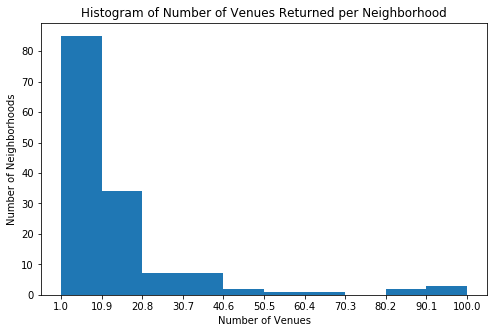

In [48]:
venue_counts = zagreb_venues['Neighborhood'].value_counts().reset_index()
venue_counts.columns = ['Neighborhood', 'count']

# build a histogram of venues returned per neighborhood
count, bin_edges = np.histogram(venue_counts['count'])

venue_counts['count'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Number of Venues Returned per Neighborhood') # add a title to the histogram
plt.ylabel('Number of Neighborhoods') # add y-label
plt.xlabel('Number of Venues') # add x-label

plt.show()

We see that for **more than 80 neighborhoods we got less than 10 venues**. This is more than a half of all the neighborhoods. 

This can be explained by the fact that Zagreb is a big city where the population density distributed very unevenly, with a large amount of districts with low density. As mentioned in Data Acquisition section, we have scraped the population density data. Let's use this data to visualize the density frequencies with a histogram. 

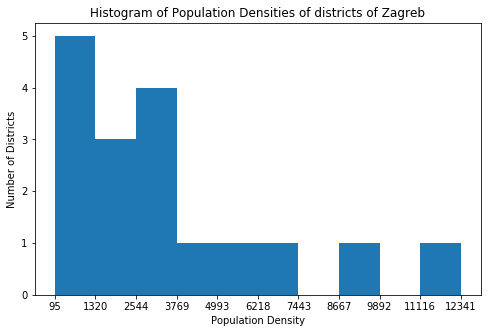

In [49]:
# build a histogram of population densities of districts of Zagreb
count, bin_edges = np.histogram(df_zagreb_districts['Density'])

df_zagreb_districts['Density'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.title('Histogram of Population Densities of districts of Zagreb') # add a title to the histogram
plt.ylabel('Number of Districts') # add y-label
plt.xlabel('Population Density') # add x-label

plt.show()

Comparing the two histograms, we see that there is definite correlation between them.

So we assume that the low-venue-number neighborhoods are mostly residential districts with very low population (and venue) density. **Let's drop these neighborhoods from our analysis**.

In [50]:
# drop the neighborhoods for which we got less than 10 venues
counts = venue_counts[venue_counts['count'] < 10]

to_drop = counts['Neighborhood'].values

zagreb_venues_reduced = zagreb_venues

for item in to_drop:
    zagreb_venues_reduced = zagreb_venues_reduced[zagreb_venues_reduced.Neighborhood != item]
print(zagreb_venues_reduced.shape)
print('Number of neighborhoods left: {}'.format(len(zagreb_venues_reduced['Neighborhood'].unique())))
print('Number of venues left: {}'.format(len(zagreb_venues_reduced['Venue ID'].unique())))
zagreb_venues_reduced.head()

(1634, 9)
Number of neighborhoods left: 60
Number of venues left: 1109


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Category,Category ID
0,Dugave,45.765037,15.997999,Buffet Mac,4c3c575a980320a16f778ae4,45.763988,16.001123,Diner,4bf58dd8d48988d147941735
1,Dugave,45.765037,15.997999,Play Off,4b7a4cb4f964a520e1282fe3,45.766285,16.001196,Café,4bf58dd8d48988d16d941735
2,Dugave,45.765037,15.997999,Goya Bar,4f1b2e23e4b0288a02d11b0f,45.763122,15.992952,Bar,4bf58dd8d48988d116941735
3,Dugave,45.765037,15.997999,Caffe Lupo,4c76752cb474a1cd61f8bbbf,45.762524,16.003188,Café,4bf58dd8d48988d16d941735
4,Dugave,45.765037,15.997999,Konzum,4d59795e56f2b60ce898792f,45.769046,15.999888,Grocery Store,4bf58dd8d48988d118951735


So we have only 60 neighborhoods left for analysis.

Let's rename zagreb_venues_reduced to zagreb_venues for convenience.

In [51]:
zagreb_venues = zagreb_venues_reduced

Let's see how many unique venue categories we are dealing with:

In [52]:
print('There are {} uniques categories.'.format(len(zagreb_venues['Venue Category'].unique())))

There are 150 uniques categories.


Now let's define a function that gets from our zagreb_venues dataframe only venues of certain categories. The same venue can be discovered from several neighborhoods. In this case, concatenate the neighborhoods in comma-separated list.

In [53]:
# Get all venues of specified category 
def getVenuesByCategory(categories_dict):
    column_names = ['Venue ID', 'Venue', 'Venue Category', 'Venue Latitude', 'Venue Longitude', 'Neighborhood'] 
    venues = pd.DataFrame(columns=column_names)
    venues.set_index('Venue ID', inplace=True)

    for index, row in zagreb_venues.iterrows():
        if row['Category ID'] in categories_dict:
            venue_id = row['Venue ID'] 
            if venue_id in venues.index:
                oldNeigh = venues.loc[venue_id, 'Neighborhood']
                neigh = oldNeigh + ", " + row['Neighborhood']
                venues.loc[venue_id, 'Neighborhood'] = neigh
            else:
                venues.loc[venue_id] = [row['Venue'], row['Venue Category'], \
                                      row['Venue Latitude'], row['Venue Longitude'], row['Neighborhood']]
    return venues

Let's use this function to create dataframes containing only venues of specified categories.

In [54]:
nightlife_venues = getVenuesByCategory(nightlife_categories_dict)
arts_venues = getVenuesByCategory(arts_categories_dict)
music_venues = getVenuesByCategory(music_categories_dict)

Let's take a look at nightlife venues:

In [55]:
print(nightlife_venues.shape)
nightlife_venues.head()

(154, 5)


,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood
Venue ID,,,,,
4f1b2e23e4b0288a02d11b0f,Goya Bar,Bar,45.763122,15.992952,Dugave
4d2dd2ffcd5f60fc5f14ae9c,U.O. Gajba,Bar,45.774578,15.996787,Travno
4ca5fb15931bb60cf0bd8ee2,Caffe bar Four Roses,Bar,45.770663,15.950099,Lanište
4cc327cf06c2548166a28e47,Caffe bar Orange,Bar,45.772755,15.952175,Lanište
556e00bb498e00b5a09e9355,A'e caffe bar,Bar,45.776710,15.972314,Siget


Let's take a look at Arts venues:

In [56]:
print(arts_venues.shape)
arts_venues.head()

(31, 5)


,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood
Venue ID,,,,,
4b800f93f964a520994e30e3,Arena Zagreb,Concert Hall,45.771382,15.943492,Lanište
530668db498e96262b9f2e6d,Hard place,Concert Hall,45.796765,15.978836,"Trnje, Trnje-Suburb"
4b51cd9cf964a520215627e3,Koncertna dvorana Vatroslava Lisinskog,Concert Hall,45.800668,15.979983,"Martinovka, Trnje-Suburb"
4d6145199f67f04d646d82fb,Knap,Theater,45.808389,16.018001,Volovčica
4d333c965c2db60c485dc96c,Kulturni Centar Pescenica,Theater,45.808406,16.018088,Volovčica


Let's look at music venues:

In [57]:
print(music_venues.shape)
music_venues.head()

(7, 5)


,Venue,Venue Category,Venue Latitude,Venue Longitude,Neighborhood
Venue ID,,,,,
4f89db17e4b07efb9e3eee7c,Zapruđe Uživo,Music Venue,45.780162,15.996115,Zapruđe
4bc4b786920eb713cd281f2c,Spunk,Rock Club,45.796258,15.978996,"Trnje, Trnje-Suburb"
4be3309e99feb713b70182f6,Bacchus Jazz Bar,Jazz Club,45.806356,15.977552,Donji grad
5194b0f650193eab824b0af8,Rock klub Ribnjak,Rock Club,45.816002,15.980296,Gornji grad
4d190bd0cc216ea89a7e7ad3,Hard Place,Rock Club,45.812998,15.995196,"Petrova, Donji grad - East"


### Clustering the Neighborhoods

We will use **k-means clustering** to segment the neighborhoods according to the frequncies of venue categories.

Let's create one-hot encoding for the categories in zagreb_venues dataset.

In [58]:
# one hot encoding
zagreb_onehot = pd.get_dummies(zagreb_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
zagreb_onehot['Neighborhood'] = zagreb_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [zagreb_onehot.columns[-1]] + list(zagreb_onehot.columns[:-1])
zagreb_onehot = zagreb_onehot[fixed_columns]

zagreb_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Food & Drink Shop,French Restaurant,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kids Store,Korean Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Radio Station,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,South American Restaurant,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tennis Stadium,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Water Park,Wine Bar,Women's Store,Zoo
0,Dugave,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dugave,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dugave,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dugave,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dugave,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [59]:
zagreb_onehot.shape

(1634, 151)

Let's compute the frequency of occurence of each category in the neighborhood. We can do this by grouping zagreb_onehot by neighborhood and calculating the mean values.

In [60]:
zagreb_grouped = zagreb_onehot.groupby('Neighborhood').mean().reset_index()
zagreb_grouped.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bakery,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Bistro,Bookstore,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish Market,Flea Market,Food & Drink Shop,French Restaurant,Furniture / Home Store,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hardware Store,Health Food Store,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Karaoke Bar,Kids Store,Korean Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Paper / Office Supplies Store,Park,Pedestrian Plaza,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Radio Station,Rental Car Location,Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Soccer Field,South American Restaurant,Sports Bar,Sports Club,Sri Lankan Restaurant,Stables,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tennis Stadium,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Train,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Volleyball Court,Water Park,Wine Bar,Women's Store,Zoo
0,Cvjetno naselje,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.125000,0.0,0.000000,0.166667,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.458333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.041667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.041667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.083333,0.00000,0.041667,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.041667,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,Donji grad,0.011236,0.000000,0.0,0.0,0.0,0.000000,0.011236,0.0,0.011236,0.067416,0.0,0.0,0.000000,0.011236,0.011236,0.033708,0.000000,0.011236,0.0,0.0,0.022472,0.0,0.0,0.0,0.101124,0.0,0.0,0.0,0.0,0.0,0.000000,0.033708,0.0,0.011236,0.0,0.000000,0.0,0.011236,0.0,0.011236,0.011236,0.044944,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.011236,0.000000,0.0,0.011236,0.0,0.000000,0.0,0.0,0.0,0.011236,0.0,0.011236,0.0,0.011236,0.000000,0.000000,0.000000,0.0,0.011236,0.011236,0.011236,0.033708,0.0,0.056180,0.0,0.0,0.0,0.011236,0.033708,0.022472,0.011236,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.044944,0.011236,0.0,0.0,0.011236,0.0,0.000000,0.0,0.0,0.000000,0.022472,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.067416,0.0,0.0,0.011236,0.0,0.0,0.0,0.056180,0.00000,0.011236,0.0,0.011236,0.011236,0.011236,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.011236,0.0,0.0,0.011236,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.

In [61]:
zagreb_grouped.shape

(60, 151)

Let's create the dataframe that contains the same columns as zagreb_grouped, except the 'Neighborhood' column. We will use this dataframe for clustering.

In [62]:
zagreb_grouped_clustering = zagreb_grouped.drop('Neighborhood', 1)

Let's build the dataframe that shows the top 10 categories for each neighborhood.

First, define a helper function that takes a row containing the category frequencies for a neighborhood, sorts them in the descending order, and returns top N categories.

In [63]:
# Helper function to return top num_top_venues categories for a neighborhood.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Use this function defined above to get a dataframe containing top 10 categories for each neighborhood.

In [64]:
# Create a dataframe and populate it with top 10 categories of each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = zagreb_grouped['Neighborhood']

for ind in np.arange(zagreb_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(zagreb_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Cvjetno naselje,Café,Bar,BBQ Joint,Restaurant,Pizza Place,Supermarket,Salad Place,Grocery Store,Dog Run,Donut Shop
1,Donji grad,Café,Plaza,Bar,Hotel,Restaurant,Mediterranean Restaurant,Dessert Shop,Coffee Shop,Hostel,Italian Restaurant
2,Donji grad - East,Café,Bar,Dessert Shop,Bakery,Mediterranean Restaurant,Bistro,Rock Club,Restaurant,Plaza,BBQ Joint
3,Donji grad - West,Café,Restaurant,Park,BBQ Joint,Grocery Store,Pizza Place,Theater,Stadium,Beer Garden,Beer Bar
4,Dubrava,Hotel,Bar,Burger Joint,Supermarket,Café,Multiplex,Gym / Fitness Center,Gym,Drugstore,Light Rail Station


### Determine optimal k for k-means clustering

We will use the **elbow method** to find optimal number of clusters.

In [65]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [66]:
# For k from 1 to 10, do k-means clustering and compute mean distance of data points to cluster centroids.  
distances = []
K = range(1,10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(zagreb_grouped_clustering)
    distances.append(sum(np.min(cdist(zagreb_grouped_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1)) / zagreb_grouped_clustering.shape[0])


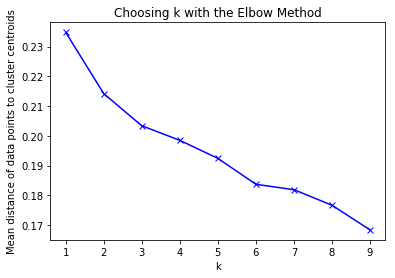

In [67]:
plt.plot(K, distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Mean distance of data points to cluster centroids')
plt.title('Choosing k with the Elbow Method')
plt.show()

k=6 seems the elbow here, so let's use this.

In [68]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(zagreb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([2, 5, 1, 1, 5, 2, 2, 1, 5, 1, 5, 1, 2, 1, 1, 5, 1, 2, 5, 5, 0, 0,
       2, 2, 5, 1, 1, 5, 3, 1, 4, 1, 5, 2, 1, 5, 1, 1, 3, 1, 5, 5, 1, 1,
       5, 2, 2, 1, 1, 1, 5, 2, 1, 1, 2, 5, 1, 5, 2, 1], dtype=int32)

In [69]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(60, 12)


,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Cvjetno naselje,Café,Bar,BBQ Joint,Restaurant,Pizza Place,Supermarket,Salad Place,Grocery Store,Dog Run,Donut Shop
1,5,Donji grad,Café,Plaza,Bar,Hotel,Restaurant,Mediterranean Restaurant,Dessert Shop,Coffee Shop,Hostel,Italian Restaurant
2,1,Donji grad - East,Café,Bar,Dessert Shop,Bakery,Mediterranean Restaurant,Bistro,Rock Club,Restaurant,Plaza,BBQ Joint
3,1,Donji grad - West,Café,Restaurant,Park,BBQ Joint,Grocery Store,Pizza Place,Theater,Stadium,Beer Garden,Beer Bar
4,5,Dubrava,Hotel,Bar,Burger Joint,Supermarket,Café,Multiplex,Gym / Fitness Center,Gym,Drugstore,Light Rail Station


In [70]:
neighborhoods_venues_sorted.shape

(60, 12)

In [71]:
zagreb_merged = neighborhoods

# merge neighborhood dataframe with neighborhood_venues_sorted to add latitude/longitude for each neighborhood
zagreb_merged = zagreb_merged.merge(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
print(zagreb_merged.shape)
zagreb_merged.head()

(60, 14)


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dugave,45.765037,15.997999,2,Café,Bus Station,Diner,Bakery,Bar,Sushi Restaurant,Grocery Store,Zoo,Falafel Restaurant,Fish Market
1,Travno,45.770753,15.997835,1,Café,Smoke Shop,Grocery Store,Bakery,Bar,Drugstore,Bus Station,Donut Shop,Eastern European Restaurant,Dog Run
2,Utrina,45.775019,15.997538,1,Café,Soccer Field,Bakery,Supermarket,Electronics Store,Eastern European Restaurant,Sandwich Place,Coffee Shop,Grocery Store,Light Rail Station
3,Lanište,45.772431,15.947718,1,Café,Pizza Place,Grocery Store,Bar,Hotel,Multiplex,Dessert Shop,Vegetarian / Vegan Restaurant,Concert Hall,Seafood Restaurant
4,Siget,45.774506,15.975134,1,Café,Bakery,Bar,Clothing Store,Gym,Drugstore,Grocery Store,Women's Store,Soccer Field,Smoke Shop


In [72]:
# Helper function to add clusters to the map
def mapClusters(geo_map):
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(zagreb_merged['Latitude'], zagreb_merged['Longitude'], zagreb_merged['Neighborhood'], zagreb_merged['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(geo_map)

In [73]:
# create map
map_clusters = folium.Map(location=[zagreb_latitude, zagreb_longitude], zoom_start=12)

mapClusters(map_clusters)

map_clusters

### Examine the Clusters

Let's see what neighborhoods comprise the clusters, and what are their distinguishing features. 

In [74]:
cluster0 = zagreb_merged.loc[zagreb_merged['Cluster Labels'] == 0, zagreb_merged.columns[[0] + list(range(4, zagreb_merged.shape[1]))]]
print('Number of neighborhoods in cluster0: {}'.format(cluster0.shape[0]))
cluster0.head()

Number of neighborhoods in cluster0: 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Otok Veslača,Bar,Nightclub,Athletics & Sports,Café,Sports Bar,Garden Center,Restaurant,Baseball Field,Pizza Place,Volleyball Court
35,Otok Ljubavi,Bar,Nightclub,Athletics & Sports,Café,Sports Bar,Garden Center,Restaurant,Baseball Field,Pizza Place,Volleyball Court


In [75]:
cluster1 = zagreb_merged.loc[zagreb_merged['Cluster Labels'] == 1, zagreb_merged.columns[[0] + list(range(4, zagreb_merged.shape[1]))]]
print('Number of neighborhoods in cluster1: {}'.format(cluster1.shape[0]))
cluster1.head()

Number of neighborhoods in cluster1: 25


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Travno,Café,Smoke Shop,Grocery Store,Bakery,Bar,Drugstore,Bus Station,Donut Shop,Eastern European Restaurant,Dog Run
2,Utrina,Café,Soccer Field,Bakery,Supermarket,Electronics Store,Eastern European Restaurant,Sandwich Place,Coffee Shop,Grocery Store,Light Rail Station
3,Lanište,Café,Pizza Place,Grocery Store,Bar,Hotel,Multiplex,Dessert Shop,Vegetarian / Vegan Restaurant,Concert Hall,Seafood Restaurant
4,Siget,Café,Bakery,Bar,Clothing Store,Gym,Drugstore,Grocery Store,Women's Store,Soccer Field,Smoke Shop
5,Kajzerica,Café,Restaurant,Sports Bar,Bakery,Mediterranean Restaurant,Lounge,Stables,Eastern European Restaurant,Basketball Court,Baby Store


In [76]:
cluster2 = zagreb_merged.loc[zagreb_merged['Cluster Labels'] == 2, zagreb_merged.columns[[0] + list(range(4, zagreb_merged.shape[1]))]]
print('Number of neighborhoods in cluster2: {}'.format(cluster2.shape[0]))
cluster2.head()

Number of neighborhoods in cluster2: 13


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dugave,Café,Bus Station,Diner,Bakery,Bar,Sushi Restaurant,Grocery Store,Zoo,Falafel Restaurant,Fish Market
8,Sloboština,Café,Bar,Food & Drink Shop,Grocery Store,Convenience Store,Arts & Crafts Store,Radio Station,Dessert Shop,Diner,Dog Run
10,Malešnica,Café,Bakery,Restaurant,Wine Bar,Bus Station,Train,Grocery Store,Drugstore,Fast Food Restaurant,Farmers Market
13,Vrbik,Café,Bar,Pizza Place,Restaurant,Bakery,Seafood Restaurant,Cheese Shop,Salad Place,Brewery,Bistro
14,Trnje,Café,Restaurant,Bar,Bakery,Rock Club,Rental Car Location,Supermarket,Electronics Store,Pub,College Cafeteria


In [77]:
cluster3 = zagreb_merged.loc[zagreb_merged['Cluster Labels'] == 3, zagreb_merged.columns[[0] + list(range(4, zagreb_merged.shape[1]))]]
print('Number of neighborhoods in cluster3: {}'.format(cluster3.shape[0]))
cluster3.head()

Number of neighborhoods in cluster3: 2


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Rudeš,Supermarket,Hotel,BBQ Joint,Bus Station,Fast Food Restaurant,Chinese Restaurant,Eastern European Restaurant,Restaurant,Dessert Shop,Donut Shop
41,Stenjevec,Supermarket,Clothing Store,Convenience Store,Toy / Game Store,Fast Food Restaurant,Café,Grocery Store,Kids Store,Pharmacy,Dessert Shop


In [78]:
cluster4 = zagreb_merged.loc[zagreb_merged['Cluster Labels'] == 4, zagreb_merged.columns[[0] + list(range(4, zagreb_merged.shape[1]))]]
print('Number of neighborhoods in cluster4: {}'.format(cluster4.shape[0]))
cluster4.head()

Number of neighborhoods in cluster4: 1


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
39,Savska Opatovina,Clothing Store,Shoe Store,Bar,Asian Restaurant,Pet Store,Shopping Mall,Electronics Store,Eastern European Restaurant,Field,Fast Food Restaurant


In [79]:
cluster5 = zagreb_merged.loc[zagreb_merged['Cluster Labels'] == 5, zagreb_merged.columns[[0] + list(range(4, zagreb_merged.shape[1]))]]
print('Number of neighborhoods in cluster5: {}'.format(cluster5.shape[0]))
cluster5.head()

Number of neighborhoods in cluster5: 17


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Martinovka,Café,Bar,Restaurant,Nightclub,Light Rail Station,Plaza,Bakery,Supermarket,Hotel,Casino
17,Zavrtnica,Restaurant,Sushi Restaurant,Nightclub,Hotel,Café,Diner,Bakery,Bar,Eastern European Restaurant,Burger Joint
23,Sigečica,Restaurant,Café,Bar,Hotel,Sushi Restaurant,Bakery,Chinese Restaurant,BBQ Joint,Market,Mediterranean Restaurant
29,Središće,Café,Bar,Pizza Place,Dessert Shop,Lounge,Gym,Museum,Supermarket,Zoo,Falafel Restaurant
30,Voltino,Bar,Café,Cocktail Bar,Hostel,Pharmacy,Bakery,Grocery Store,Tennis Stadium,Eastern European Restaurant,Field


Looking at each cluster's most frequent features, we can describe the clusters as follows:

- Cluster 0 - nightlife and sports 
- Cluster 1 - cafes, petstores, bakeries
- Cluster 2 - cafes
- Cluster 3 - supermarkets
- Cluster 4 - retail stores
- Cluster 5 - cafes, bars, restaurants, hotels and supermarkets

We are interested in **Cluster 5**, because this is the cluster that includes the central disricts (Zagreb, Kaptol). It is shown as **orange** circles on the map. We will be refering to it as **'orange' cluster**.

### Selecting Locations 

First, let's define a couple of helper functions to help us with visualization.

In [80]:
# Add locations of music venues to the map
def mapMusicVenues(geo_map):
    for lat, lon, venue, category, neighborhood in zip(music_venues['Venue Latitude'], music_venues['Venue Longitude'], \
                                                       music_venues['Venue'], music_venues['Venue Category'],\
                                                      music_venues['Neighborhood']):
        label = folium.Popup(str(venue) + ', ' + str(category) + ', ' + str(neighborhood), parse_html=True)
        folium.Marker(
            [lat, lon],
            popup=label,
            icon=folium.Icon(color='blue',icon='music', prefix='fa')
            ).add_to(geo_map)
        folium.Circle([lat, lon], radius=500, fill=False, color='white').add_to(geo_map)


In [81]:
# Add locations of arts venues to the map
def mapArtsVenues(geo_map):
   for lat, lon, venue, category, neighborhood in zip(arts_venues['Venue Latitude'], arts_venues['Venue Longitude'], \
                                                   arts_venues['Venue'], arts_venues['Venue Category'],\
                                                  arts_venues['Neighborhood']):
    label = folium.Popup(str(venue) + ', ' + str(category) + ', ' + str(neighborhood), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='green',
        ).add_to(geo_map) 

In [82]:
#geolocations of arts venues
arts_venues_coord = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in arts_venues.iterrows()]
#geolocations of nighlife venues
nightlife_venues_coord = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in nightlife_venues.iterrows()]

Let's see how is the density of nightlife venues is distributed by showing a heatmap of nightlife venues. 

In [83]:
# create map
zagreb_map = folium.Map(location=[zagreb_latitude, zagreb_longitude], zoom_start=12)

mapClusters(zagreb_map)

HeatMap(nightlife_venues_coord).add_to(zagreb_map)

zagreb_map

We see that the majority neighborhoods of Cluster 5 (orange cluster) are located on hot nightlife areas. Exceptions are  far north-east (3 orange neighborhoods there), and several neighborhoods south of the center. If we want the central districts, we will need to get away from the neighborhoods centers.

Now let's see the density of arts venues.

In [84]:
zagreb_map = folium.Map(location=[zagreb_latitude, zagreb_longitude], zoom_start=12)

mapClusters(zagreb_map)

HeatMap(arts_venues_coord).add_to(zagreb_map)

zagreb_map

This map is much less dense. The majority of arts venues are concentrated in the center districts. These neighborhoods are Zagreb (center), Donji grad, Gornji grad, Kaptol, Ribnjak, Tkalčićeva Street. Medveščak is slightly to the north, in the moderate density area. There is also one neighborhood to the south across the railroad with moderate arts density - Martinovka, and then farther to the south, beyond the river, a neighborhood in a low density area - Središće. 

Let's zoom-in on the central districts. We will show the heatmap of nightlife venues. We will show the locations of the music venues by the markers with the 'music' icon, and surround them by a white circle 500m radius. This would be the areas we want to stay clear of. We will show the locations of the arts venues with green circles.

In [85]:
zagreb_map = folium.Map(location=[zagreb_latitude, zagreb_longitude], zoom_start=14)

mapClusters(zagreb_map)

mapMusicVenues(zagreb_map)

mapArtsVenues(zagreb_map)

HeatMap(nightlife_venues_coord).add_to(zagreb_map)

zagreb_map

Let's select our locations. We want them to be near arts venues (green circles) and in low-to-moderate nightlife areas (purple-green on the heatmap).

We select the locations manually, using the neighborhood centers (orange) and arts venues (green) coordinates as reference points.

The following locations look good:

1. Between Hrvatsko dizajnersko drustvo, Art Gallery, Gornji grad, and Gornji grad neighborhood center
2. Around Kino Europa, Indie Movie Theater, Donji grad
3. Around Hrvatski Povijesni Muzej, History Museum, Tkalčićeva Street
4. Between Gliptoteka, Art Gallery, Medveščak and Tkalčićeva Street neighborhood center
5. Between Koncertna dvorana Vatroslava Lisinskog, Concert Hall, Martinovka, and Martinovka neighborhood center

Let's compute the coordinates of the suggested locations and store them in the dictionary suggested_locations.

First, define a helper function.

In [86]:
#Get geolocation of the venue
def getVenueLocation(dataframe, venue):
    lat = dataframe[dataframe['Venue'] == venue]['Venue Latitude'].values[0]
    lng = dataframe[dataframe['Venue'] == venue]['Venue Longitude'].values[0]
    location = [lat, lng]
    return location

In [87]:
suggested_locations = {}
suggested_locations['Gornji grad'] = findMidpoint(getVenueLocation(arts_venues, 'Hrvatsko dizajnersko drustvo'),
                                                getNeighborhoodLocation('Gornji grad'))
suggested_locations['Donji grad'] = getVenueLocation(arts_venues, 'Kino Europa')
suggested_locations['Tkalčićeva'] = getVenueLocation(arts_venues, 'Hrvatski Povijesni Muzej')
suggested_locations['Medveščak'] = findMidpoint(getVenueLocation(arts_venues, 'Gliptoteka'),
                                              getNeighborhoodLocation('Tkalčićeva Street'))
suggested_locations['Martinovka'] = findMidpoint(getNeighborhoodLocation('Martinovka'), \
                                              getVenueLocation(arts_venues, 'Koncertna dvorana Vatroslava Lisinskog'))
suggested_locations

{'Gornji grad': [45.81098720429974, 15.982906081591617],
 'Donji grad': [45.811830458317736, 15.973250475865028],
 'Tkalčićeva': [45.816000242657026, 15.972559926102864],
 'Medveščak': [45.82077975526093, 15.976792563241688],
 'Martinovka': [45.801158800861735, 15.977821861026428]}

Let's visualiza this on a map. We will show the suggested locations as red circles.

In [88]:
center = getNeighborhoodLocation('Donji grad')
zagreb_map = folium.Map(location=center, zoom_start=14)

mapClusters(zagreb_map)

mapMusicVenues(zagreb_map)

#Map suggested locations
for location, name in zip(suggested_locations.values(), suggested_locations.keys()):
    label = folium.Popup(str(name), parse_html=True)
    folium.Circle(
        location,
        popup=label,
        radius=100, fill=False, color='red'
        ).add_to(zagreb_map)

HeatMap(nightlife_venues_coord).add_to(zagreb_map)
       
zagreb_map

Now let's zoom in on the location across the river, 'Središće' neighborhood. 

Let's visualize the location on the map, adding the music venues, arts venues and the nightlife's heatmap.

In [89]:
sredisce = getNeighborhoodLocation('Središće')

In [90]:
center = sredisce

zagreb_map = folium.Map(location=center, zoom_start=14)

mapClusters(zagreb_map)

mapMusicVenues(zagreb_map)

mapArtsVenues(zagreb_map)

HeatMap(nightlife_venues_coord).add_to(zagreb_map)
       
zagreb_map

This is a nice area. The neighborhood has one arts venue nearby (green circle). This is Muzej Suvremene Umjetnosti of Zagreb (Museum of Modern Arts). The neighborhood center (orange) is located in a moderate nightlife area. Let's move from the neighborhood center halfway closer to the arts venue. Our suggested location becomes: 

In [91]:
suggested_locations['Središće'] = findMidpoint(sredisce, getVenueLocation(arts_venues, 'Muzej Suvremene Umjetnosti Zagreb (MSU)'))

In [92]:
# Show the suggested location for Sredisce on the map, with red circle.
center = sredisce
zagreb_map = folium.Map(location=center, zoom_start=14)

mapClusters(zagreb_map)

mapMusicVenues(zagreb_map)

#Map suggested locations
for location, name in zip(suggested_locations.values(), suggested_locations.keys()):
    label = folium.Popup(str(name), parse_html=True)
    folium.Circle(
        location,
        popup=label,
        radius=100, fill=False, color='red'
        ).add_to(zagreb_map)

HeatMap(nightlife_venues_coord).add_to(zagreb_map)
       
zagreb_map

<a id='section4'></a> 

## Results

Let's show all the suggested locations on the map, as green music icon markers. 

In [93]:
center = getNeighborhoodLocation('Martinovka')
zagreb_map = folium.Map(location=center, zoom_start=13)

#Map suggested locations
for location, name in zip(suggested_locations.values(), suggested_locations.keys()):
    label = folium.Popup(str(name), parse_html=True)
    folium.Marker(
            location,
            popup=label,
            icon=folium.Icon(color='green',icon='music', prefix='fa')
            ).add_to(zagreb_map)
    folium.Circle(
        location,
        radius=100, fill=False, color='green'
        ).add_to(zagreb_map)
    

zagreb_map

### Suggested Locations Summary

Let's present the summary of the suggested locations. For each location, we will give its distance from the center, the number of arts venues within 250m, the number of nightlife venues within 250m, and the number of music venues (competitors) within 500m.

In [94]:
#get the location of the center of Zagreb - Trg Bana Josipa Jelacica, the central square of the city.
zagreb = getNeighborhoodLocation('Zagreb')

In [95]:
# Get nearby venues for a location. 
# df_venues - dataframe with venues data, location - geolocation we want the venues for, 
# distance - within which distance we want the venues.
# Returns a disctionary keyed on Venue ID, values - distance of the venues from the location.
def getNearbyVenues(df_venues, location, distance):
    venues = {}
    for index, row in df_venues.iterrows():
        venue_location = [row['Venue Latitude'], row['Venue Longitude']]
        dist = geopy.distance.distance(location, venue_location).km
        if dist <= distance:
            venues[index] = dist
    return venues

Let's create a dataframe and populate it with the suggested locations summary data.

In [96]:
column_names = ['Location', 'Latitude', 'Longitude', 'Distance from Center,km', \
                'Num Arts Venues within 250m', 'Num Night Venues within 250m', 'Num Competing Music Venues within 500m']
locations_summary = pd.DataFrame(columns = column_names)
for key, value in suggested_locations.items():
    location = key
    latlng = value
    nearby_arts_venues = getNearbyVenues(arts_venues, latlng, 0.250)
    nearby_music_venues = getNearbyVenues(music_venues, latlng, 0.500)
    nearby_nightlife_venues = getNearbyVenues(nightlife_venues, latlng, 0.250)
    dist_from_center = geopy.distance.distance(latlng, zagreb).km
    locations_summary = locations_summary.append({'Location': location,
                                          'Latitude': latlng[0],
                                          'Longitude': latlng[1],
                                           'Distance from Center,km': dist_from_center,
                                          'Num Arts Venues within 250m': len(nearby_arts_venues),
                                          'Num Night Venues within 250m': len(nearby_nightlife_venues),
                                          'Num Competing Music Venues within 500m': len(nearby_music_venues)
                                                 }, ignore_index=True)
    
locations_summary.sort_values('Distance from Center,km')

,Location,Latitude,Longitude,"Distance from Center,km",Num Arts Venues within 250m,Num Night Venues within 250m,Num Competing Music Venues within 500m
1,Donji grad,45.811830,15.973250,0.330929,3,4,0
2,Tkalčićeva,45.816000,15.972560,0.469197,5,3,0
0,Gornji grad,45.810987,15.982906,0.516291,1,4,0
3,Medveščak,45.820780,15.976793,0.845270,2,0,0
4,Martinovka,45.801159,15.977822,1.337139,1,1,0
5,Središće,45.779329,15.983404,3.794393,1,1,0


<a id='section5'></a> 

## Discussion

Analyzing the venue data returned by Foursquare API, we saw that for more than half of the neighborhoods we got less than 10 venues. As we mentioned in the Data Analysis section, this is on par with the population density distribution of Zagreb. 

We dropped the neighborhoods with less than 10 venues from the analysis, but still venue frequencies were unevenly distributed, with the prevailing number of neighborhoods with 20 venues or less. This may have affected the outcome of the clustering algorithm.

We saw that 'arts' venues are mostly concentrated in the central parts of the city. This forced us to look for the desired locations in the central neighborhoods, where both, the music venue density (our first-tier competitors) and nightlife spots density (our second-tier competitors) were high, so we had to select locations carefully. Also, this prevented us from considering more remote neighborhoods from the same cluster. Still, we found two non-central locations, with one being almost 4 km from the city center.

## Conclusion

We suggested several locations for jazz cafe that satisfy the stakeholder's business requirements: they are located in the neighborhoods that are similar to the center, don't have competing music venues in the area, located near arts venues, and have low to moderate nightlife spots density. The locations fall into wide range of distancies from the city center - the closest being 300m from the center, and the most remote almost 4km from the center. 

We have provided the summary of the locations, including distance from center and the number of music, arts and nightlife venues in the vicinity. The stakeholder can choose a location and learn more about it.

There are other factors that the stakeholder would need to consider - location availability, commercial real estate prices in the area, and others. The locations we suggest fall into wide range of distancies from the city center - the closest being 300m from the center, and the most remote almost 4km from the center. This wide range gives the stakeholder more flexibility, since real estate prices may be significantly higher in the central neighborhoods than in more remote areas.